In [1]:
from DiagnosisAI.lightining_modules.binary_slices_segment import BinarySegmenterUnet
from pathlib import Path
import torch.nn as nn
import torch as t
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from DiagnosisAI.datasets_torch.brain_slices_dataset import BrainSlicesDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from DiagnosisAI.utils.metrics import calc_metrics, calculate_type_errors
from torchmetrics import JaccardIndex
import matplotlib

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics_cols = ['train_Precision', 'train_Recall', 'train_F1Score',
       'train_Accuracy', 'train_JaccardIndex',
       'val_Precision', 'val_Recall', 'val_F1Score', 'val_Accuracy',
       'val_JaccardIndex']

In [3]:
logs = pd.read_csv('../trainings/logs/binary_segment_unet/resnet34/metrics.csv')
logs = logs.groupby('epoch').mean()

In [4]:
logs[metrics_cols] = logs[metrics_cols] * 100

In [5]:
log_train_loss = logs['train_loss']
log_val_loss = logs['val_loss']
epochs = np.arange(1, len(log_val_loss) + 1)

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

Text(0, 0.5, 'Wartość binarnej entropii krzyżowej')

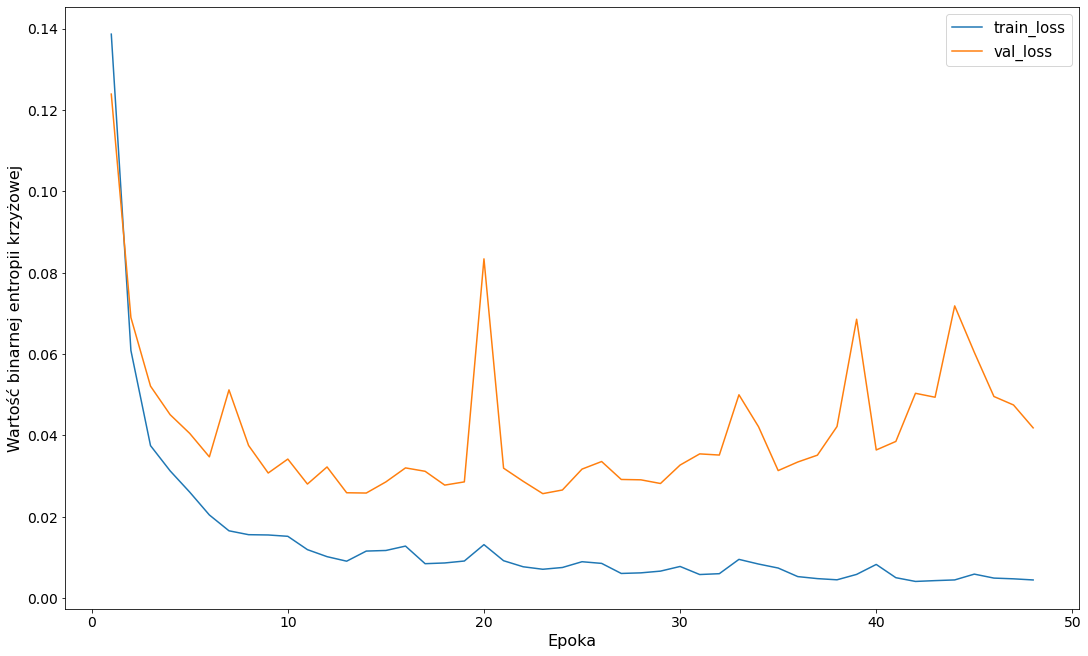

In [125]:
fig, ax = plt.subplots(figsize=(15, 9), constrained_layout=True)

ax.plot(epochs, log_train_loss)
ax.plot(epochs, log_val_loss)
ax.legend(["train_loss", "val_loss"], loc=0, prop={'size': 15})
ax.set_xlabel('Epoka', size=16)
ax.set_ylabel('Wartość binarnej entropii krzyżowej', size=16)

Text(0, 0.5, 'Wartość [%]')

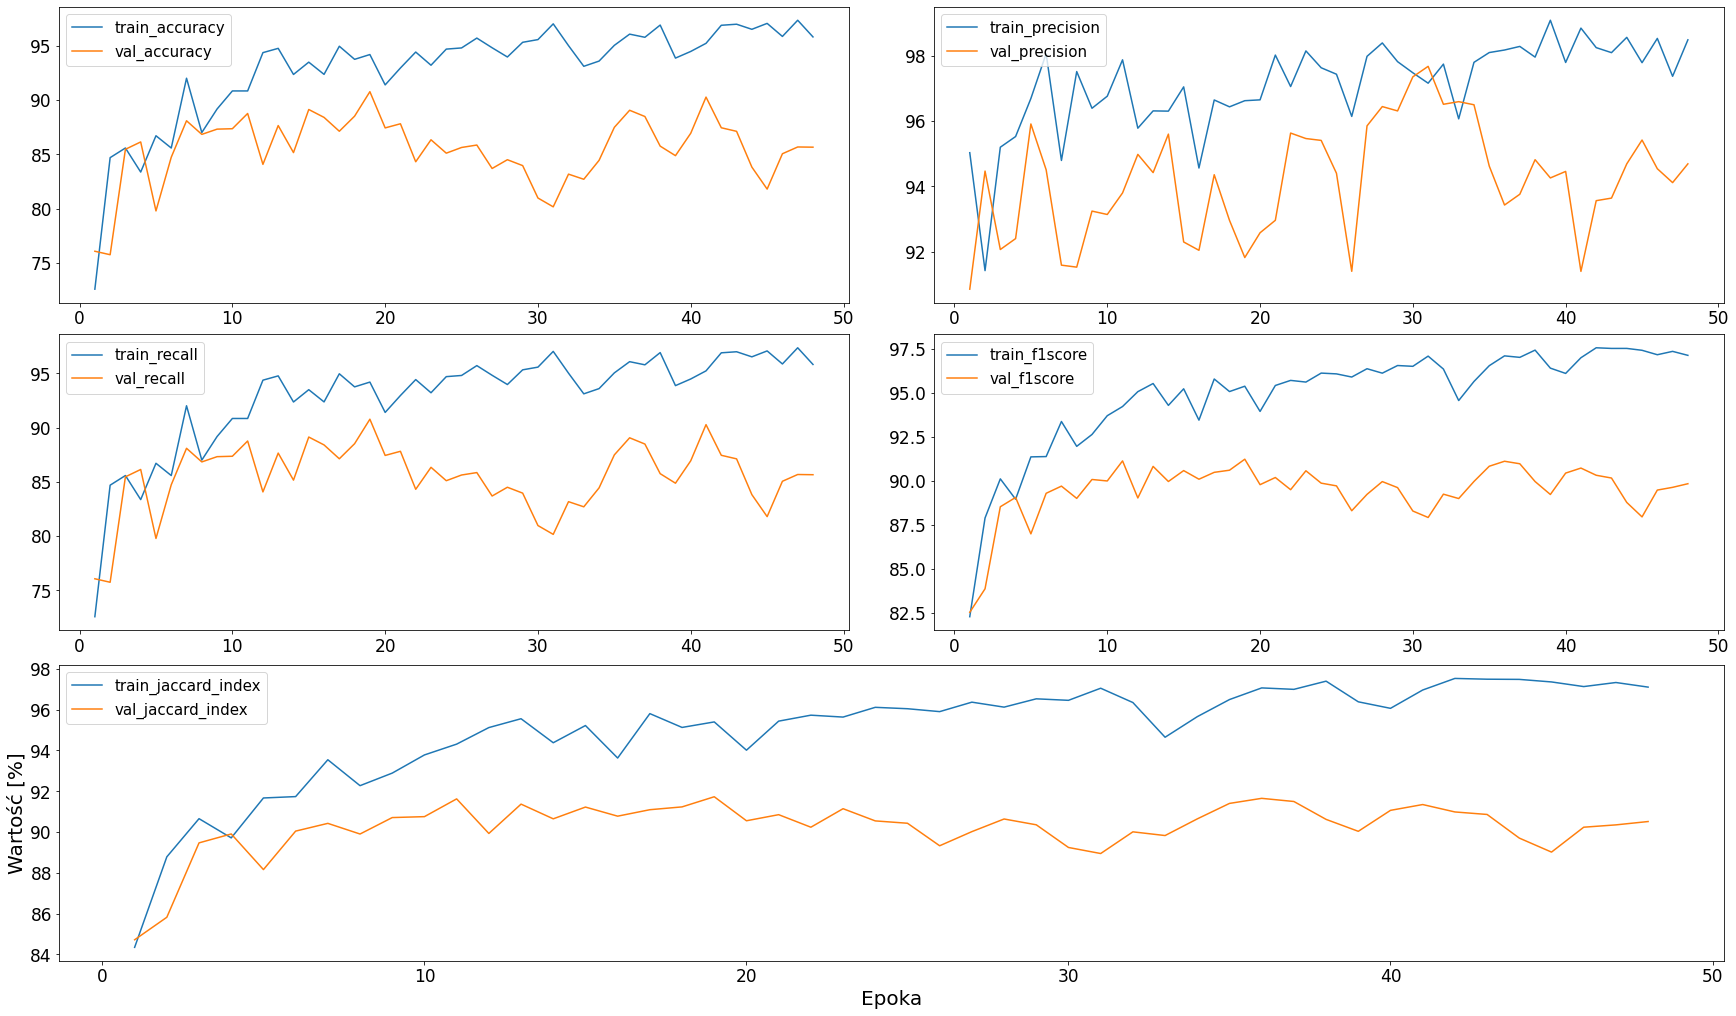

In [14]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(24, 14), constrained_layout=True)
spec = fig.add_gridspec(3, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax10 = fig.add_subplot(spec[1, 0], sharex=ax00)
ax11 = fig.add_subplot(spec[1, 1], sharex=ax01)
ax2 = fig.add_subplot(spec[2, :])
ax00.plot(epochs, logs['train_Accuracy'])
ax00.plot(epochs, logs['val_Accuracy'])
ax00.legend(['train_accuracy', 'val_accuracy'], loc=0, prop={'size': 15})
ax01.plot(epochs, logs['train_Precision'])
ax01.plot(epochs, logs['val_Precision'])
ax01.legend(['train_precision', 'val_precision'], loc=0, prop={'size': 15})
ax10.plot(epochs, logs['train_Recall'])
ax10.plot(epochs, logs['val_Recall'])
ax10.legend(['train_recall', 'val_recall'], loc=0, prop={'size': 15})
ax11.plot(epochs, logs['train_F1Score'])
ax11.plot(epochs, logs['val_F1Score'])
ax11.legend(['train_f1score', 'val_f1score'], loc=0, prop={'size': 15})
ax2.plot(epochs, logs['train_JaccardIndex'])
ax2.plot(epochs, logs['val_JaccardIndex'])
ax2.legend(['train_jaccard_index', 'val_jaccard_index'], loc=0, prop={'size': 15})
ax2.set_xlabel('Epoka', size=20)
ax2.set_ylabel('Wartość [%]', size=20)

In [134]:
pl_model = BinarySegmenterUnet()
path = "../datasets/brain/train_images_max_area/"
checkpoint_path = "./checkpoints/binary_segment_unet/resnet34/"
model_state_path = "./model_states/binary_segment_unet/resnet34/"
batch_size = 1
num_workers = 4
train_size = 0.7
seed = 42

In [135]:
def __get_filenames_from_dir__(path:str):
    filenames_pickle = []
    for dir in Path(path).iterdir():
        for filename in dir.iterdir():
            rel_path = Path(*filename.parts[-2:])
            filenames_pickle.append(rel_path)

    return filenames_pickle

In [136]:
print("Getting filenames ...")
test_size = 1 - train_size
filenames = __get_filenames_from_dir__(path)
train_names, val_names = train_test_split(filenames, test_size=test_size, random_state=seed)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=seed)

Getting filenames ...


In [137]:
train_dataset = BrainSlicesDataset(train_names)
val_dataset = BrainSlicesDataset(val_names)
test_dataset = BrainSlicesDataset(test_names)

In [138]:
pl_model.load_state_dict(t.load('../trainings/model_states/binary_segment_unet/resnet34/checkpoint.ckpt'))

<All keys matched successfully>

test model on dataset and eval metrics

In [132]:
global_acc = 0.0
global_prec = 0.0
global_f1score = 0.0
global_recall = 0.0
global_ji = 0.0
global_tp = 0
global_fp = 0
global_tn = 0
global_fn = 0

pl_model.eval()
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = pl_model(img.unsqueeze(0))
    output = nn.Sigmoid()(output)
    output = t.where(output >= 0.5, 1, output)

    tp, fp, tn, fn = calculate_type_errors(output, label, mode='segment_binary')
    recall, precision, acc, f1_score = calc_metrics(tp, fp, tn, fn)
    ji = JaccardIndex(num_classes=2)(output, label.type(t.int32).unsqueeze(0)).item()

    global_ji += ji
    global_acc += acc
    global_prec += precision
    global_f1score += f1_score
    global_recall += recall

    global_tp += tp
    global_fp += fp
    global_tn += tn
    global_fn += fn

recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)
jiii = global_tp / (global_tp + global_fp + global_fn)
print(recall, precision, acc, f1_score, jiii)


print(f"Acc: {global_acc / (i+1)}, Recall: {global_recall / (i+1)}, F1score: {global_f1score / (i+1)}, Precision: {global_prec / (i+1)}, IoU: {global_ji / (i+1)}")

100%|██████████| 188/188 [00:43<00:00,  4.35it/s]

tensor(0.9301) tensor(0.9547) tensor(0.9960) tensor(0.9422) tensor(0.8907)
Acc: 0.9959938526153564, Recall: 0.9145854115486145, F1score: 0.9344592690467834, Precision: 0.9603967070579529, IoU: 0.9403920577878647



ekstrakcja cech

In [139]:
temp_network = pl_model.network
temp_network = temp_network.encoder
temp_network.eval()

ResNetEncoder(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [140]:
embeddings = []
t1ce_images = []
labels = []
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = temp_network(img.unsqueeze(0))
        output = output[-1]
        output = nn.AdaptiveAvgPool2d(output_size=(1, 1))(output)
        output = output.squeeze().numpy()
        output = output.reshape(1, -1)

    t1ce_images.append(img[3].numpy())
    labels.append(label.numpy())
    embeddings.append(output)
    del output
embeddings = np.array(embeddings)
embeddings = embeddings.squeeze()

100%|██████████| 188/188 [01:47<00:00,  1.75it/s]


/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 2.086015
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.547215
[t-SNE] KL divergence after 800 iterations: 0.342189


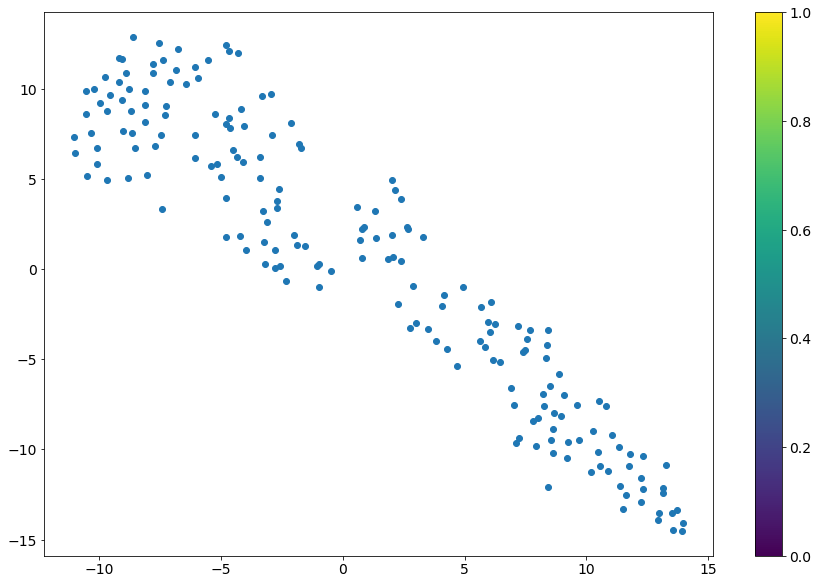

In [142]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1])
plt.colorbar()

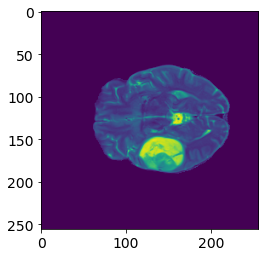

In [266]:
plt.imshow(t1ce_images[160])

In [267]:
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[160]])
indices = indices.flatten()

k_nearest = indices[0:5]
nearest_dist = distances.flatten()[0:5].round(2)
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1].round(2)

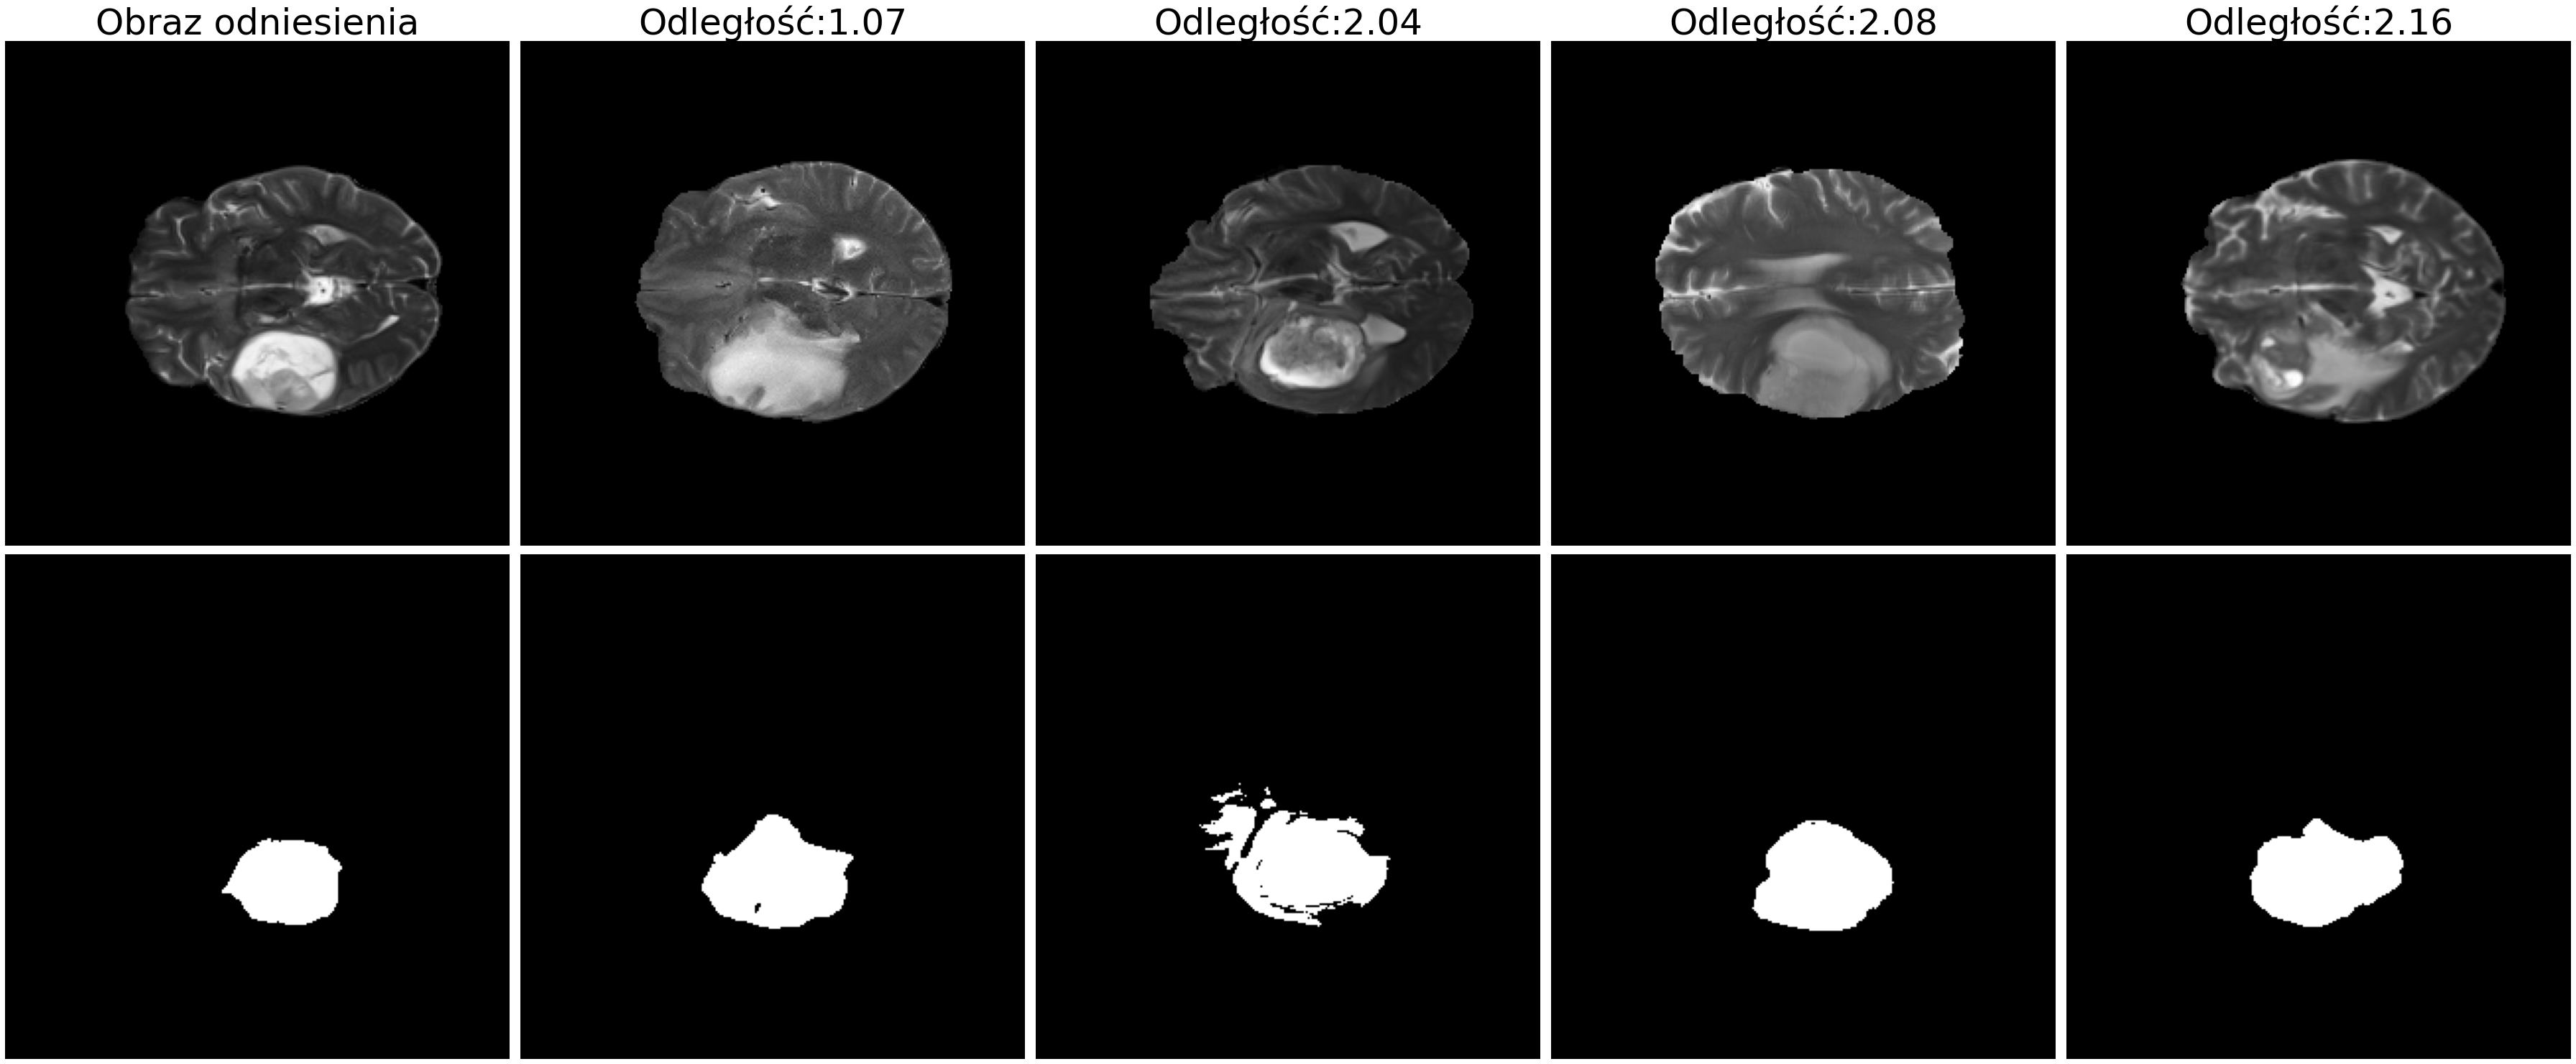

In [268]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_nearest):
    ax[0, i].imshow(t1ce_images[idx], cmap='gray')
    ax[1, i].imshow(labels[idx][0], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(nearest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 0].set_title('Obraz odniesienia', size=50)
fig.tight_layout()

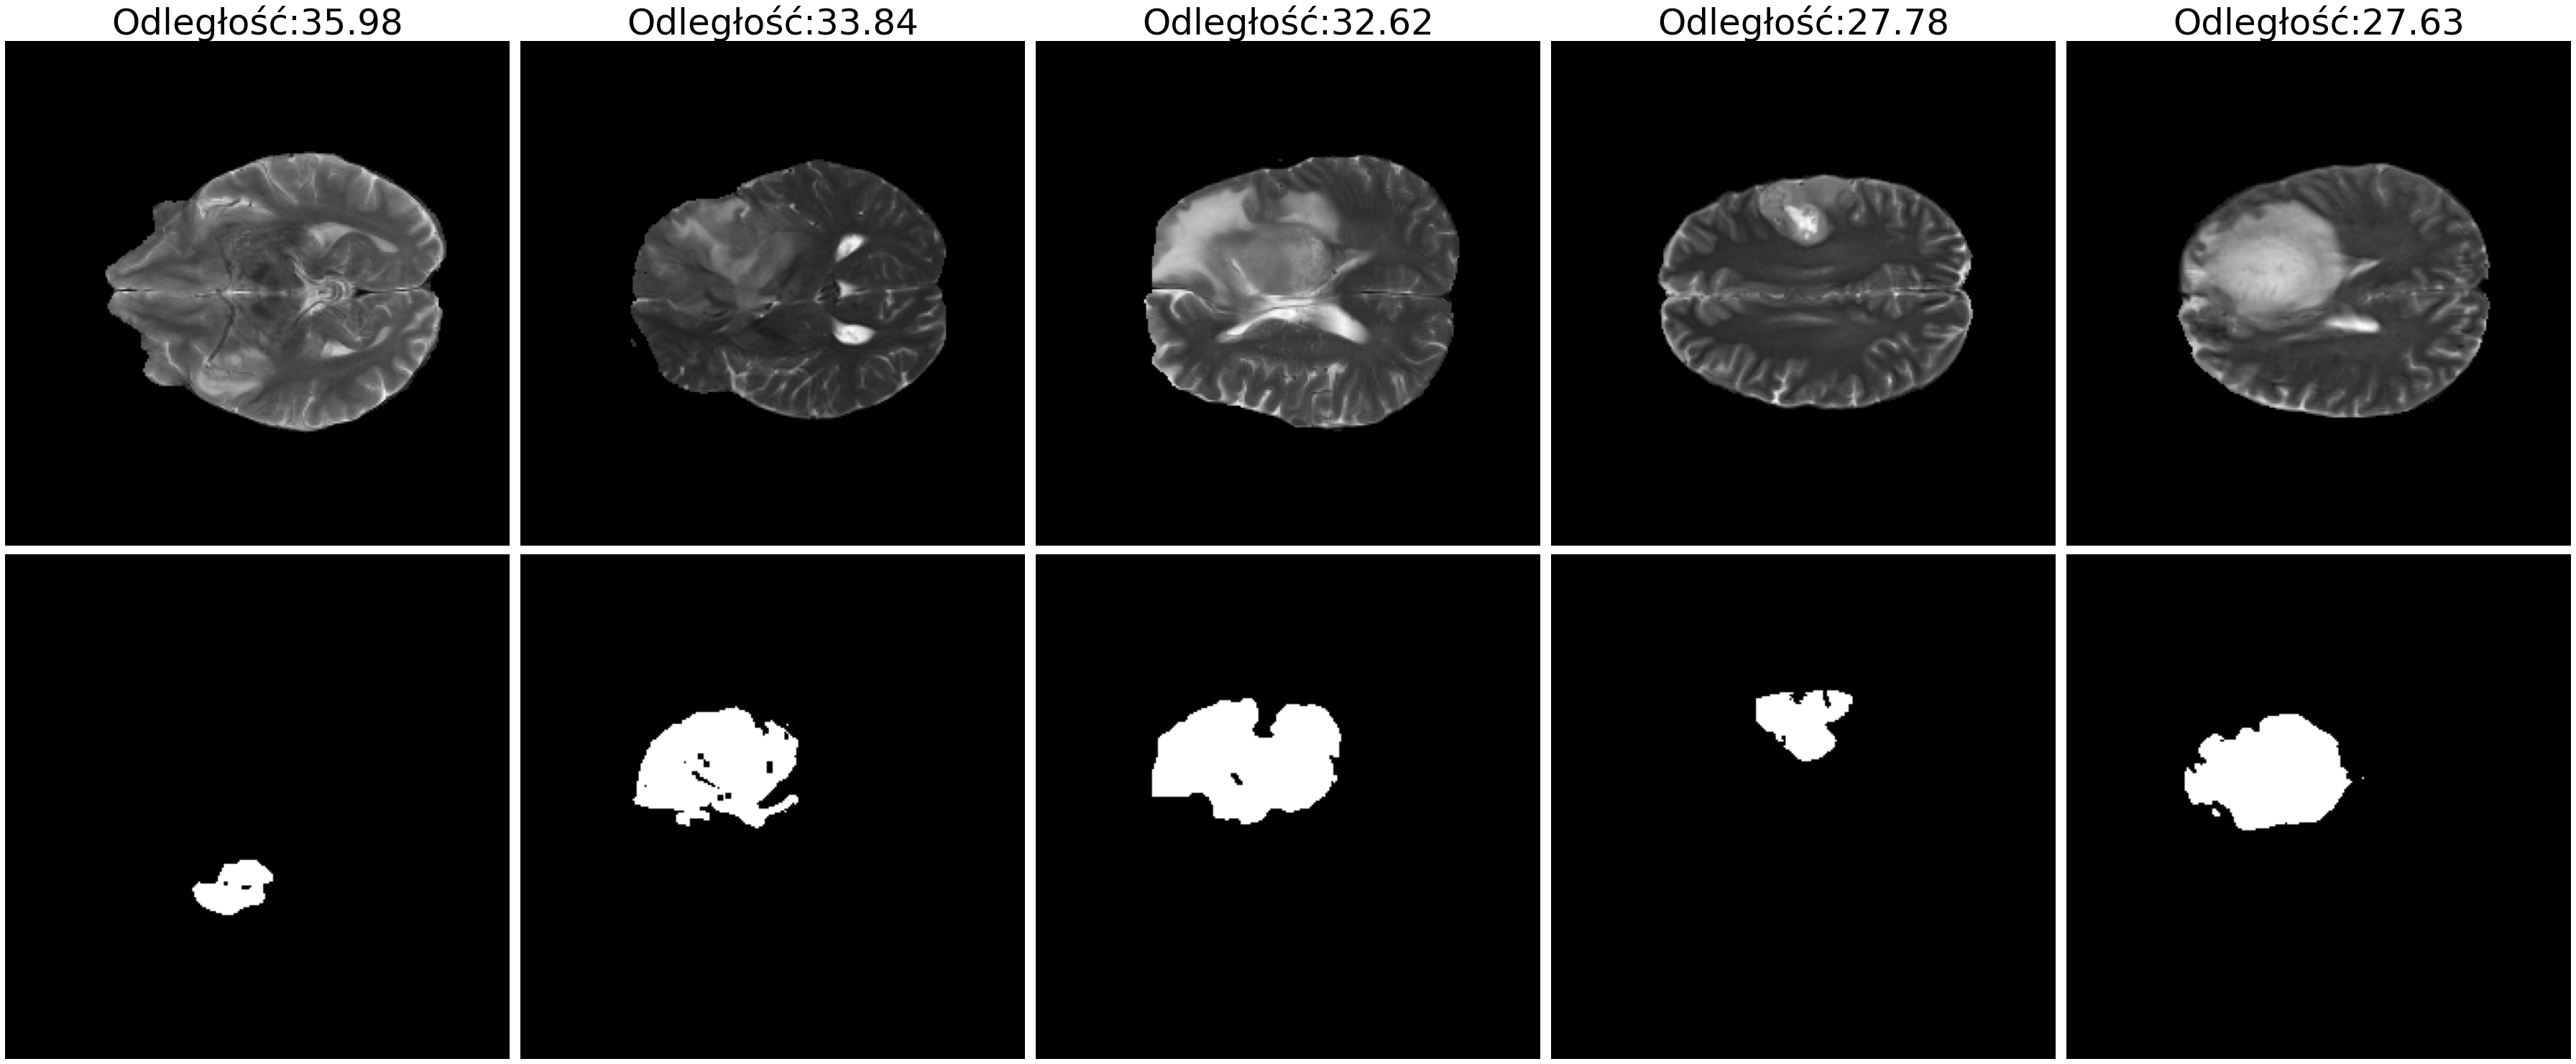

In [258]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_furthest):
    ax[0, i].imshow(t1ce_images[idx], cmap='gray')
    ax[1, i].imshow(labels[idx][0], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(furthest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
fig.tight_layout()

In [257]:
test_names[133]

PosixPath('BraTS2021_00089/BraTS2021_00089_slices_dict.pickle')